In [61]:
from os import path
from collections import Counter
import pycountry
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from functools import reduce
import numpy as np
%matplotlib inline

In [2]:
def text_cleaning(text):
    # Convert all words to lower case
    text = text.lower()    
    # Tokenize the text while removing all words with less than 3 characters
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w{3,}')
    token_text = tokenizer.tokenize(text)
    # Remove common words from the text
    s = set(nltk.corpus.stopwords.words('english'))
    token_text = list(filter(lambda x: x not in s, token_text))
    return ' '.join(token_text)

In [3]:
df = pd.read_csv(path.join('hillary-clinton-emails', 'emails.csv'))
raw_text = df['ExtractedBodyText'].dropna().reset_index(drop=True)
clean_text = raw_text.map(text_cleaning)

In [4]:
def text_cleaning(text):
    # Convert all words to lower case
    text = text.lower()    
    # Tokenize the text while removing all words with less than 3 characters
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w{3,}')
    token_text = tokenizer.tokenize(text)
    # Remove common words from the text
    s = set(nltk.corpus.stopwords.words('english'))
    token_text = list(filter(lambda x: x not in s, token_text))
    return ' '.join(token_text)

In [5]:
clean_text = raw_text.map(text_cleaning)

In [6]:
sentim_analyzer = SentimentIntensityAnalyzer()
plr_scores = clean_text.map(sentim_analyzer.polarity_scores)
compound_scores = plr_scores.map(lambda x: x['compound'])

In [12]:
countries_dict = {country.alpha_2: [country.alpha_2.lower(),
                                    country.alpha_3.lower(),
                                    country.name.split(",")[0].lower()]
                  for country in pycountry.countries}

In [13]:
countries_dict['GB'].extend(['uk', 'united kingdom', 'great britain'])
countries_dict['US'].extend(['u.s.', 'u.s.a'])
countries_dict['RU'].append('russia')
countries_dict['KP'].append('north korea')
countries_dict['KR'].append('south korea')
countries_dict['SY'].append('syria')

In [14]:
excluded_words = ['am', 'as', 'at', 'bf', 'cc', 'cv', 'ee', 'eh', 'gf', 'gg', 'id', 'co'
                  'ie', 'im', 'in', 'is', 'it', 'no', 'np', 'pm', 'tf', 'to', 'us',
                  'arm', 'can', 'com', 'col', 'mac', 'and', 'are', 'ago']

In [15]:
def search_for_countries(text):
    result = []
    for key, values in countries_dict.items():
        for value in values:
            if len(value.split()) == 1:
                if (value in text.split()) and (value not in excluded_words):
                    result.append(key)
                    break
                else:
                    pass
            else:
                if value in text:
                    result.append(key)
                    break
                else:
                    pass
    return result

In [16]:
countries_existed = clean_text.map(search_for_countries)

In [123]:
# Falttening the list
all_countires = reduce(lambda x,y: x+y,countries_existed)
# Calculating the frequency of the countires
counts = np.asarray(list(map(lambda x:all_countires.count(x),list(countries_dict.keys()))))

In [124]:
def score_countries(text,scores):
    result = []
    for key, values in countries_dict.items():
        for value in values:
            if len(value.split()) == 1:
                if (value in text.split()) and (value not in excluded_words):
                    result.append(key)
                    break
                else:
                    pass
            else:
                if value in text:
                    result.append(key)
                    break
                else:
                    pass
    return result

In [349]:
scores = np.zeros(len(counts))
for i,country_name in enumerate(list(countries_dict.keys())):
    for j,country in enumerate(countries_existed):
        if country_name in country:
            scores[i] += compound_scores[j]
average_polar = scores/(counts+1*(counts==0))
average_polar

array([ 0.9941    ,  0.99746667,  0.5267    ,  0.41039286,  0.22940678,
        0.70884762,  0.63198276,  0.        ,  0.46316667, -0.926     ,
        0.9038    , -0.128     ,  0.6673    ,  0.226525  ,  0.15052667,
        0.28015   ,  0.        ,  0.        ,  0.        ,  0.646     ,
       -0.0055    ,  0.        ,  0.02782   ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.04396667,
        0.        ,  0.5830913 ,  0.36615   ,  0.21408333,  0.        ,
        0.        ,  0.        ,  0.4147    ,  0.34      ,  0.22430667,
        0.41309167,  0.        ,  0.        ,  0.        ,  0.48053333,
        0.        ,  0.35082738,  0.        ,  1.        ,  0.52635217,
        0.408425  ,  0.        , -0.02095   ,  0.5352    ,  0.        ,
        0.        ,  0.45324545,  0.42091765,  0.43129211,  0.7842    ,
        0.377125  ,  0.        ,  0.9925    ,  0.        ,  0.3262    ,
        0.28405   ,  0.543525  ,  0.        ,  0.6705    ,  0.  

In [216]:
data_country = pd.DataFrame({'name':list(countries_dict.keys())})
data_country['count'] = counts
data_country['polar'] = average_polar
data_country = data_country.sort(['polar'])
data_country = data_country.set_index(['name'])

/Users/salehi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [266]:
data_country_frequent = data_country[data_country['count']>35]
len(data_country_frequent)

17

In [363]:
data_country_frequent.index

FrozenList(['name'])

<Container object of 17 artists>

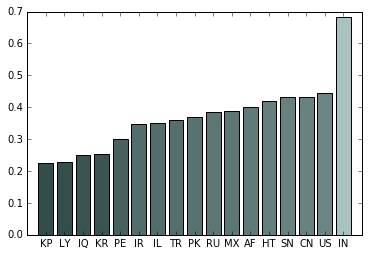

In [364]:
colors = []
bins = np.arange(1,len(data_country_frequent)+1)
std_polar = np.std(data_country_frequent['polar'])
max_polar = np.max(data_country_frequent['polar'])
for i in data_country_frequent['polar']:
    colors.append(i)
colors -= np.min(colors)
#colors /= np.max(colors)
colors_f = []
for col in colors:
    colors_f.append((0.2+col,0.3+col,0.3+col))
plt.bar(bins,data_country_frequent['polar'],color=colors_f, tick_label=data_country_frequent.index,align='center')
        

In [331]:
colors = []
for i in data_country_frequent['polar']:
    colors.append(i)
colors -= np.min(colors)
colors

array([ 0.        ,  0.00510011,  0.02747476,  0.02764116,  0.07750527,
        0.1239197 ,  0.12652071,  0.13476556,  0.14544556,  0.16207152,
        0.16272154,  0.17723605,  0.1942343 ,  0.20698544,  0.20936507,
        0.22033635,  0.45951198])

In [311]:
(429+320-2*156)/11 - 177.26*2/6

-19.35939393939394

In [344]:
data_country_frequent

,count,polar
name,,
KP,45,0.224307
LY,59,0.229407
IQ,70,0.251781
KR,46,0.251948
PE,67,0.301812
IR,110,0.348226
IL,84,0.350827
TR,36,0.359072
PK,90,0.369752


In [368]:
countries_dict['HT']

['ht', 'hti', 'haiti']